<a href="https://colab.research.google.com/github/lijingwang/DataScienceForGeosciences/blob/main/Ch1_EVS/Colabs/Ch1_EVS_4_protocol_frequency_of_extremes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Science for the Geosciences, 2022
       
Author: Lijing Wang (lijing52@stanford.edu)



---


In this notebook, we will follow the protocol of extreme events predictions with the time scale and apply that protocol to the volcanic eruption dataset. We will predict the return level of 2000 years and the return period of VEI = 8. 


**Expected learning outcomes**:   
You will learn how to use the extreme value theory we learned to make predictions for the time series data! 


Time-blocking plots
Exponential quantile plots
Histogram of bootstrap estimates of
Fitted return levels vs empirical return levels, including confidence intervals
If , add the maximum magnitude to the return level plot



In [ ]:
# load the necessary module
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Load the volcanic eruption dataset

In [ ]:
# Clone data from our GitHub repository
! git clone https://github.com/lijingwang/DataScienceForGeosciences.git

Cloning into 'DataScienceForGeosciences'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 369 (delta 83), reused 116 (delta 48), pack-reused 203
Receiving objects: 100% (369/369), 48.63 MiB | 28.02 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [ ]:
# load volcano dataset 
## Reference literature: Recurrence rates of large explosive volcanic eruptions, https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009JB006554 
volcano_data = pd.read_csv('/content/DataScienceForGeosciences/Ch1_EVS/volcano_data.txt',
                           sep="\t", header=None, index_col = False,
                           skiprows=7, names = ['M', 'Year.MonthDay', 'Volcano location'])

## Extract volcano eruption year
volcano_data['Year'] =  np.array(volcano_data['Year.MonthDay'].str.split(pat = '.', expand = True).values[:,0],dtype = 'int64')

In [ ]:
volcano_data = volcano_data[volcano_data['Year']>1750]

# Plot 1: Magnitude vs time of all events

Text(0, 0.5, 'Eruption Magnitude')

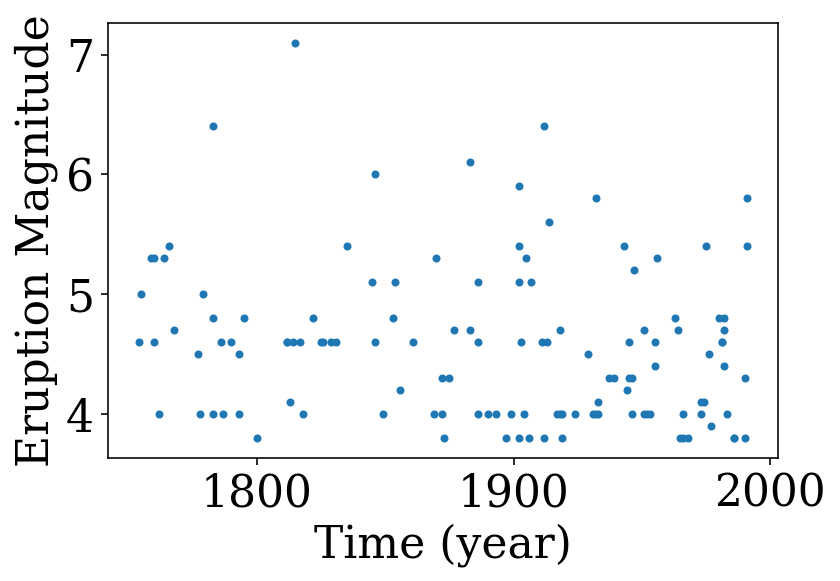

In [ ]:
matplotlib.rcParams.update({'font.size': 22})
plt.plot(volcano_data['Year'], volcano_data['M'],'.')
plt.xlabel('Time (year)')
plt.ylabel('Eruption Magnitude')

# Plot 2: Time-blocking plots (Block Maxima)

Let's take block size = 10 years, and find the distribution of maxima (You can tune the block size and see how the amount of maxima changes):

In [ ]:
block_size = 10
volcano_data['Year_bins'] = np.array((volcano_data['Year']-1750)/block_size,dtype = 'int64')
volcano_maxima = [np.argmax(volcano_data['M'][volcano_data['Year_bins'] == i]) for i in range(np.max(volcano_data['Year_bins'])+1)]
volcano_maxima = [volcano_data[volcano_data['Year_bins'] == i].values[volcano_maxima[i],[0,3]] for i in range(np.max(volcano_data['Year_bins'])+1)]

Text(0.5, 1.0, 'Block Maxima')

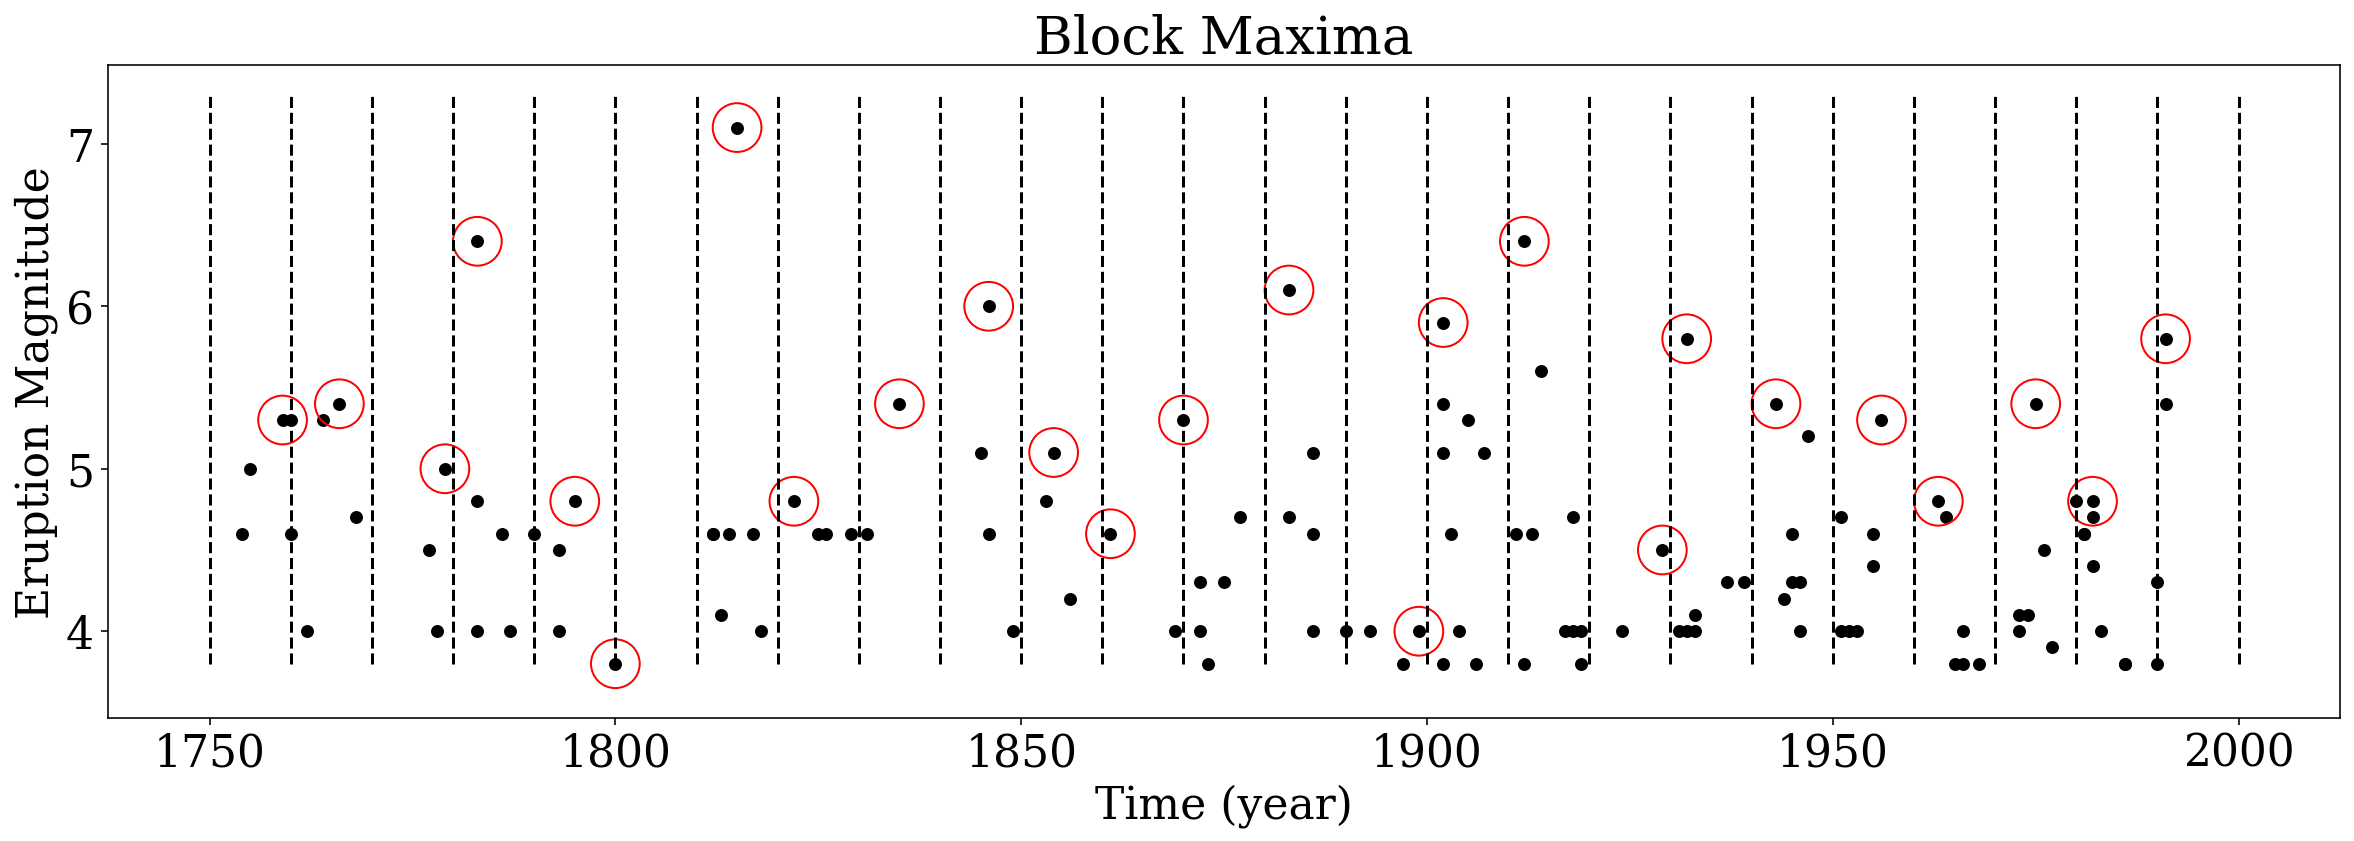

In [ ]:
matplotlib.rc("figure", figsize=(20,6))
plt.scatter(volcano_data['Year'], volcano_data['M'],s = 30, color = 'black')
plt.xlabel('Time (year)')
plt.ylabel('Eruption Magnitude')
for year in np.linspace(1750,2000,np.int(250/block_size+1)): 
    plt.vlines(x = year, ymin = 3.8,ymax = 7.3,linestyles='--')

for M,year in volcano_maxima:
    circle = matplotlib.patches.Ellipse((year, M), 0.3*20, 0.3, color='red',fill = False)
    plt.gca().add_patch(circle)
plt.title('Block Maxima')

Text(0, 0.5, 'Probability density')

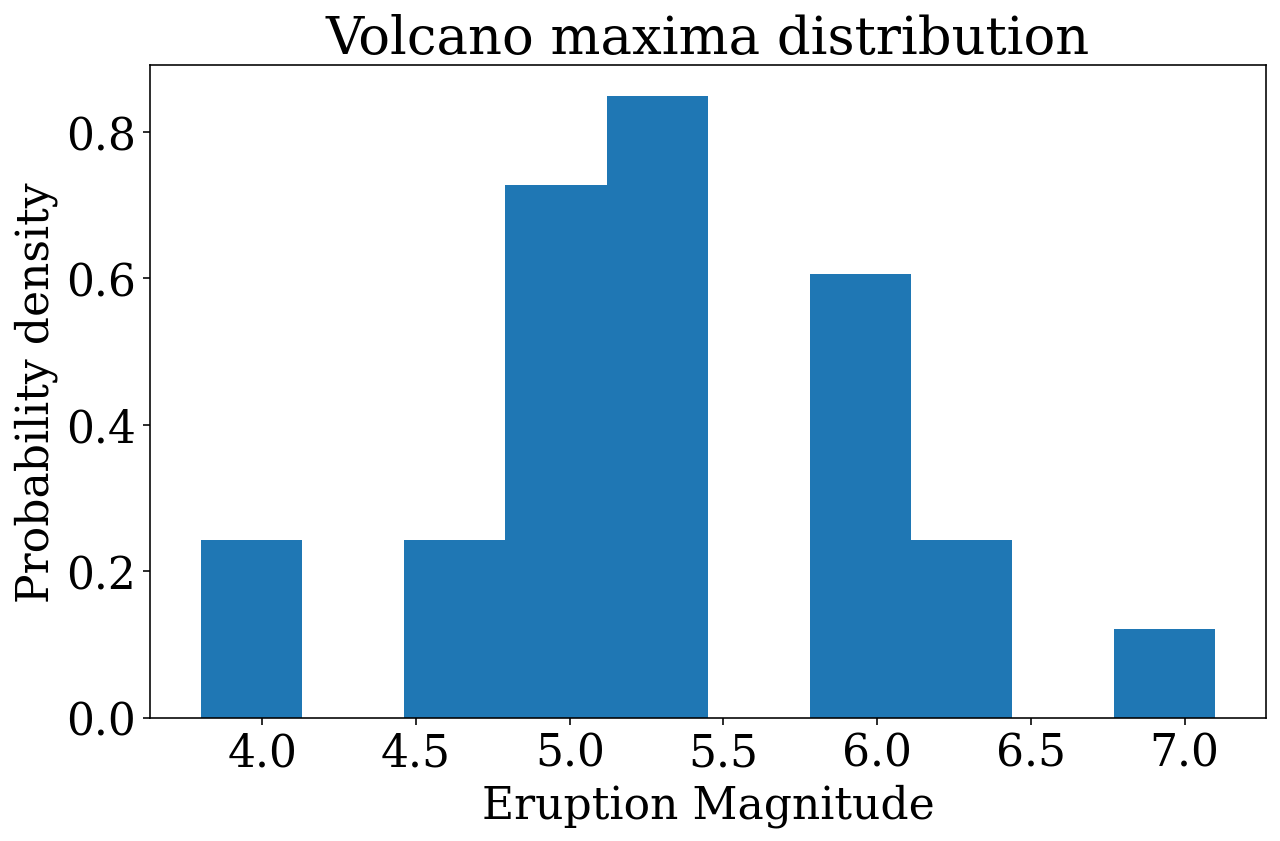

In [ ]:
matplotlib.rc("figure", figsize=(10,6))
volcano_maxima = np.array([volcano_maxima[i][0] for i in range(len(volcano_maxima))])
plt.hist(volcano_maxima,density = True)
plt.title('Volcano maxima distribution')
plt.xlabel('Eruption Magnitude')
plt.ylabel('Probability density')

In [ ]:
print('amount of observed maxima: '+str(len(volcano_maxima)))

amount of observed maxima: 25


If $\xi = 0$, the Generalized extreme value distribution (GEV) is: 

$$P(X\leq x) \sim \exp(-\exp(-x))$$

The return period $T(x)$ is: 
$$T(x) = \frac{1}{P(X>x)} = \frac{1}{1-P(X\leq x)}$$

Therefore, there is a linear relationship between maxima $x$ and $-\log(-\log (p))$, $p = P(X\leq x) = 1-\frac{1}{T}$

In [ ]:
volcano_max_unique = np.unique(np.array(volcano_maxima)) #x
p = np.array([np.mean(volcano_maxima<value) for value in volcano_max_unique])
T = block_size*1/(1-p)

Text(0, 0.5, 'Maxima')

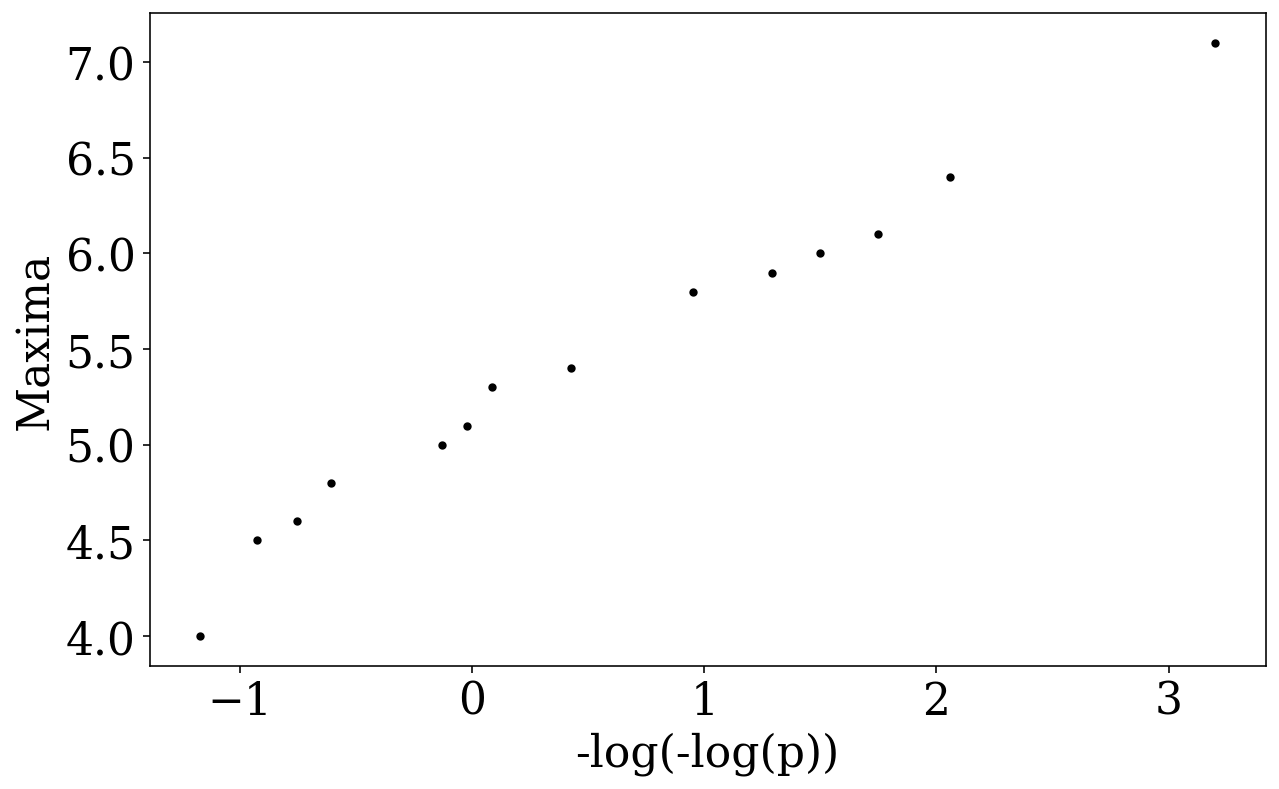

In [ ]:
plt.scatter(-np.log(-np.log(p)),volcano_max_unique,  s = 10, color = 'black')
plt.xlabel('-log(-log(p))')
plt.ylabel('Maxima')

Text(0, 0.5, 'Return period, maxima')

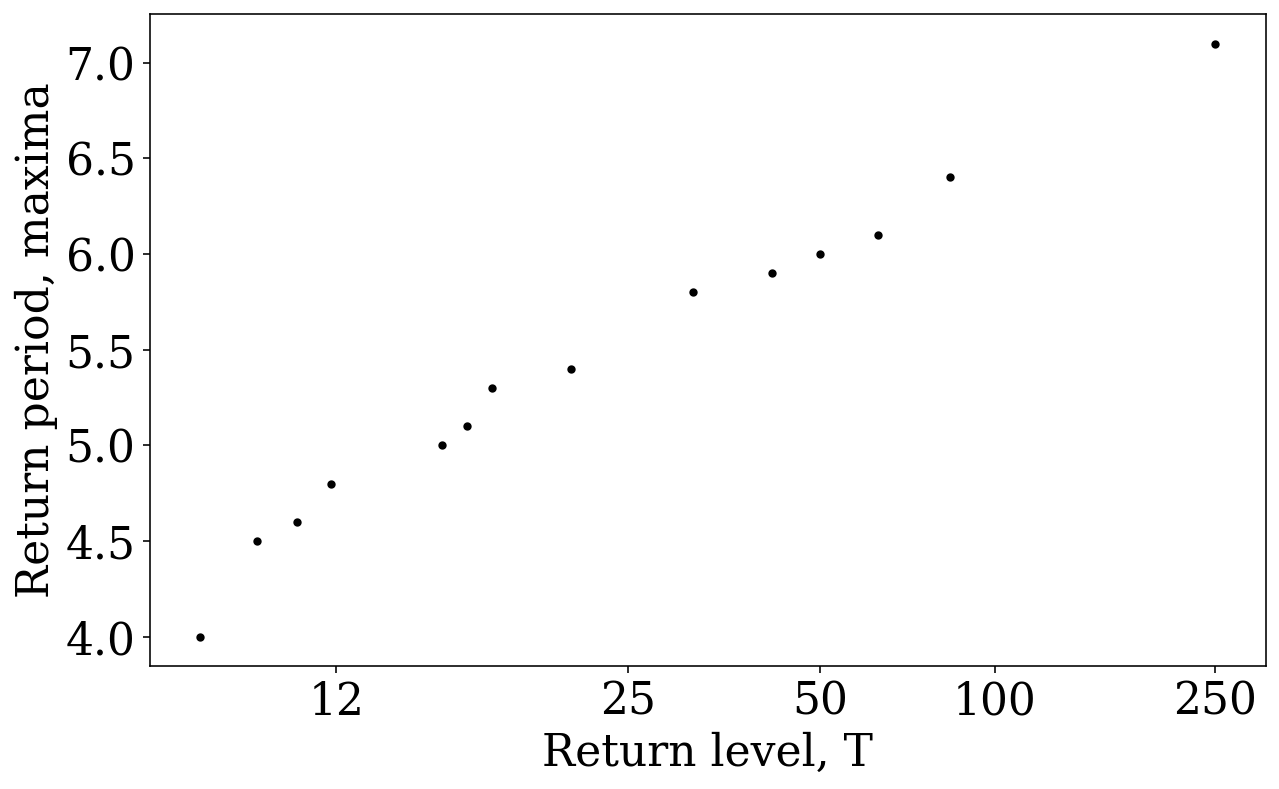

In [ ]:
plt.scatter(-np.log(-np.log(p)),volcano_max_unique, s = 10, color = 'black')
plt.xticks(-np.log(-np.log(1-block_size/np.array([12,25,50,100,250]))),[12,25,50,100,250])
plt.xlabel('Return level, T')
plt.ylabel('Return period, maxima')

# Plot 3: Exponential quantile plots

In [ ]:
def exponential_quantile(data, title = None,label = 'number of occurrence'):
    data = np.sort(data)[::-1]
    n = len(data)
    data_unique,data_counts = np.unique(data,return_counts = True) # Unique the value to address artifacts of repeated categorical values
    data_unique = data_unique[::-1]
    data_counts = data_counts[::-1]
    plt.scatter(-np.log10((np.cumsum(data_counts))/(n+1)),data_unique, s = 100, c = data_counts, edgecolors = 'k',cmap = 'Reds')
    plt.xlabel('$-\log(i/(n+1))$')
    plt.ylabel('$x_i^*$')
    plt.title(title)
    plt.colorbar(label=label)

Text(0.5, 1.0, 'Exponential quantile plot: u = 5.5')

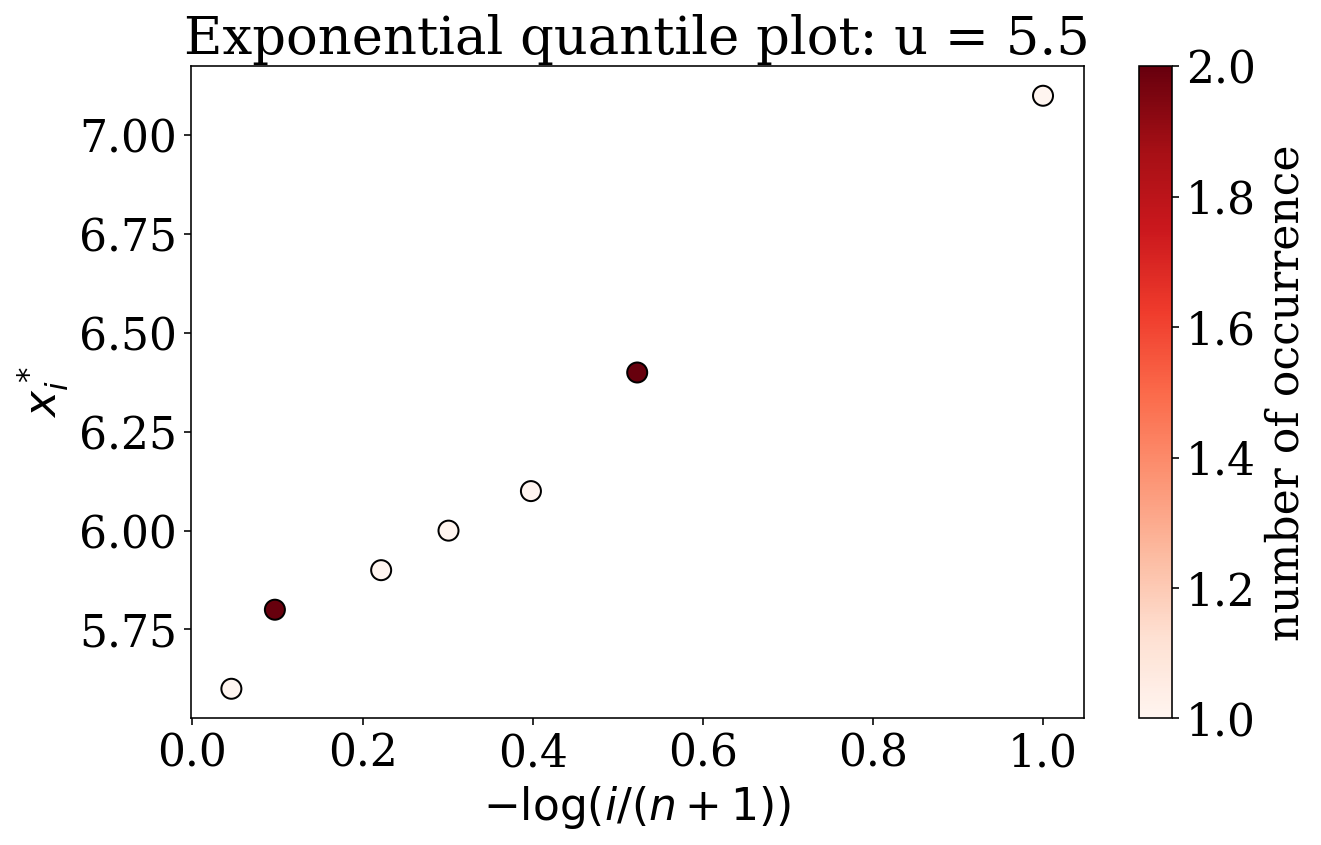

In [ ]:
u = 5.5
exponential_quantile(volcano_data['M'][volcano_data['M']>u])
plt.title('Exponential quantile plot: u = '+str(u))

Text(0.5, 1.0, 'Exponential quantile plot: u = 5')

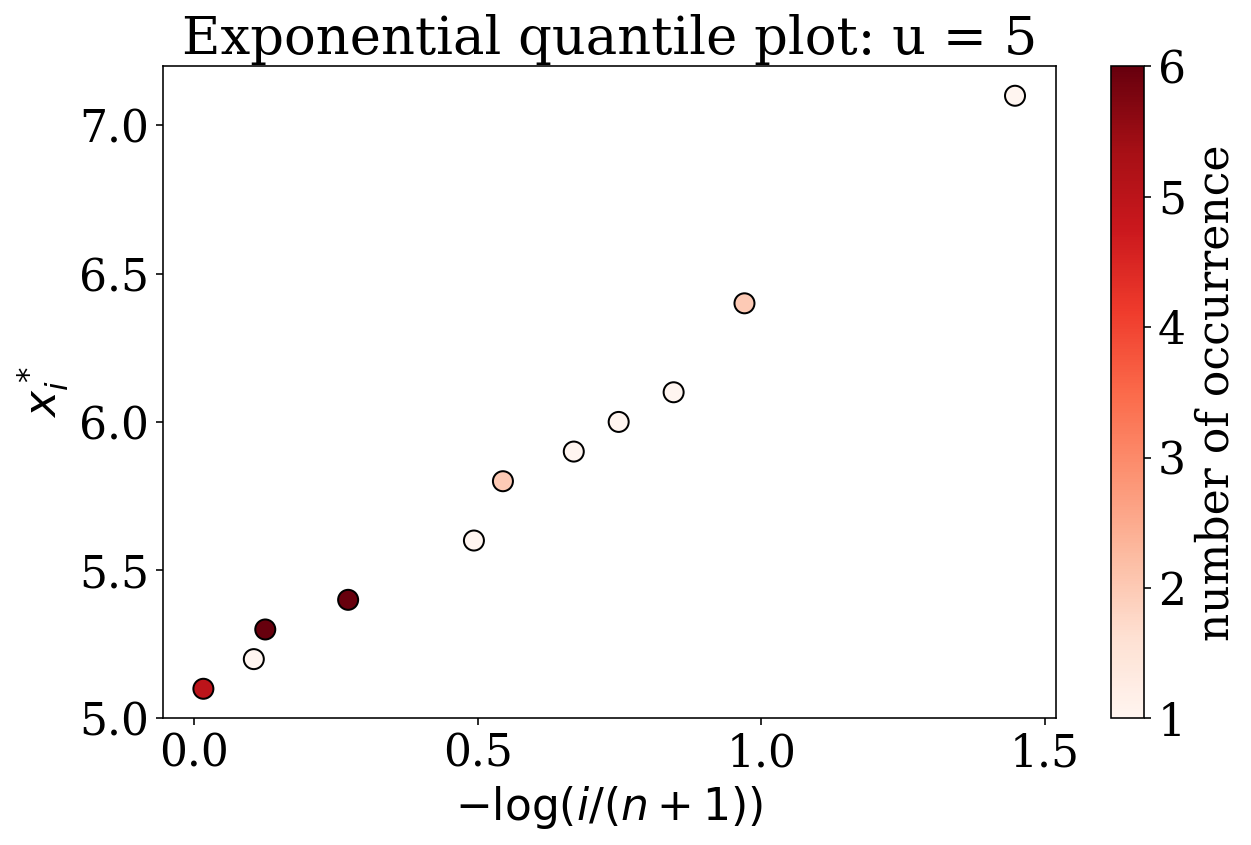

In [ ]:
u = 5
exponential_quantile(volcano_data['M'][volcano_data['M']>u])
plt.title('Exponential quantile plot: u = '+str(u))

Text(0.5, 1.0, 'Exponential quantile plot: u = 4')

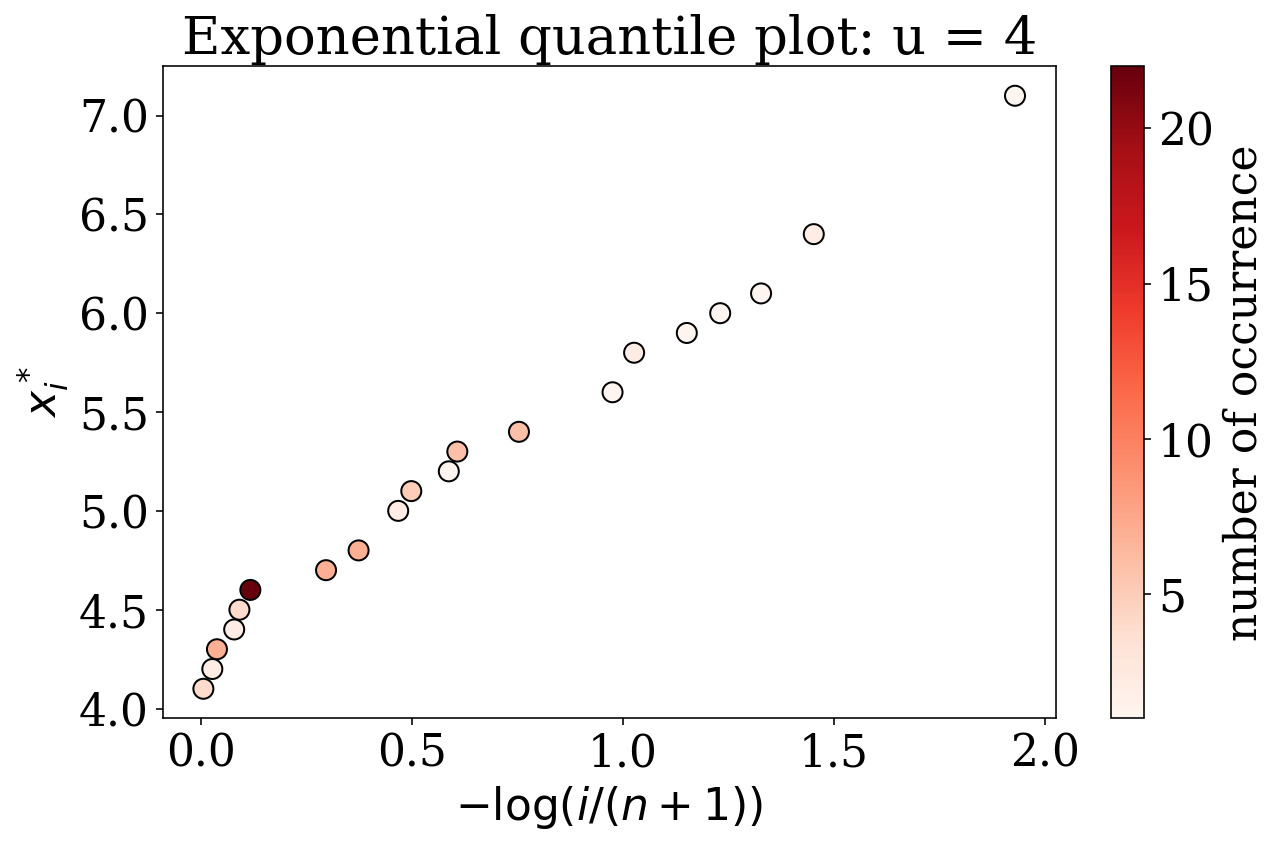

In [ ]:
u = 4
exponential_quantile(volcano_data['M'][volcano_data['M']>u])
plt.title('Exponential quantile plot: u = '+str(u))

# Plot 4: Histogram of bootstrap estimates of $\xi$

## Mean excess quantile plot to estimate $\xi$

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def mean_excess_quantile(data):
    data = np.sort(data)[::-1]
    n = len(data)
    data_unique, data_counts = np.unique(data,return_counts = True) # Unique the value to address artifacts of repeated categorical values
    data_unique = data_unique[::-1]
    data_counts = data_counts[::-1]
    log_mean_excess = np.zeros(len(data_unique))
    log_mean_excess[:] = np.nan
    for k in range(len(data_unique)):
        log_mean_excess[k] = np.log10(np.mean(data[data>=data_unique[k]]) - data_unique[k])
    log_quantile = -np.log10((np.cumsum(data_counts))/(n+1))
    return log_mean_excess,log_quantile

In [ ]:
data = volcano_data['M']
data = np.sort(data)[::-1]

log_mean_excess,log_quantile = mean_excess_quantile(data)

u = 0.5
n = len(data)
X = log_quantile.reshape(-1,1)
y = log_mean_excess
idx = np.int(np.where(X>=u)[0][-1])
threshold = np.unique(data)[::-1][idx]

Text(0, -0.45, '$\\hat{ξ}  = $-0.24')

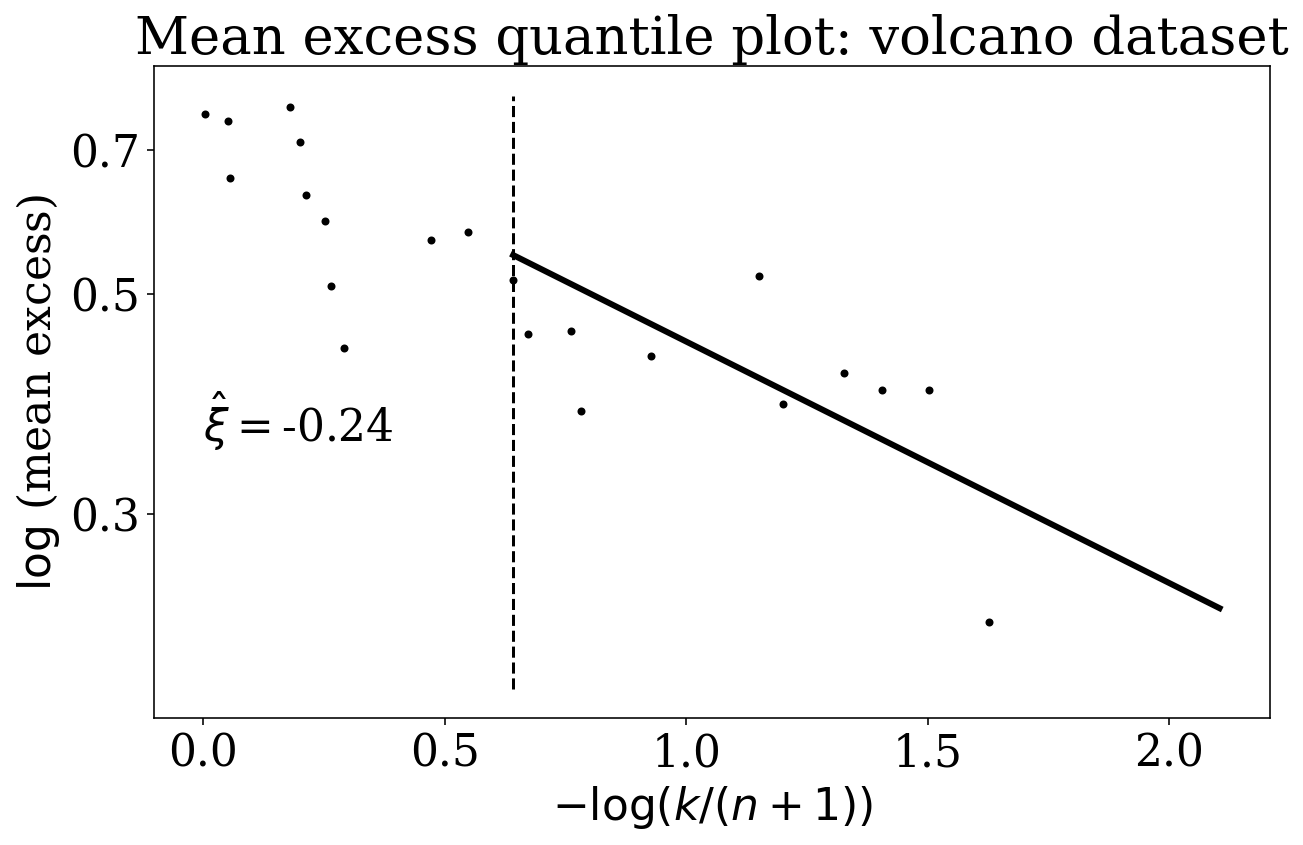

In [ ]:
plt.plot(log_quantile,log_mean_excess,'.',color = 'black')
plt.xlabel('$-\log(k/(n+1))$')
plt.ylabel('$\log$ (mean excess)')
plt.yticks(np.log10([0.3,0.5,0.7]),[0.3,0.5,0.7])
plt.title('Mean excess quantile plot: volcano dataset')

reg = LinearRegression(fit_intercept = False).fit(X[1:idx,:]-X[idx,:],y[1:idx]-y[idx])
plt.plot(X[:idx,:],reg.predict(X[:idx,:]-X[idx,:])+y[idx],'-',linewidth = 3,color = 'black')
plt.vlines(x = X[idx-1,:],ymin = -0.7,ymax = -0.1,linestyle = '--')
plt.text(0,-0.45,'$\hat{\u03BE}  = $'+str(np.round(reg.coef_[0],2)))

## Bootstrap to estimate the uncertainty of $\xi$

Text(0, 0.5, 'number of bootstrap')

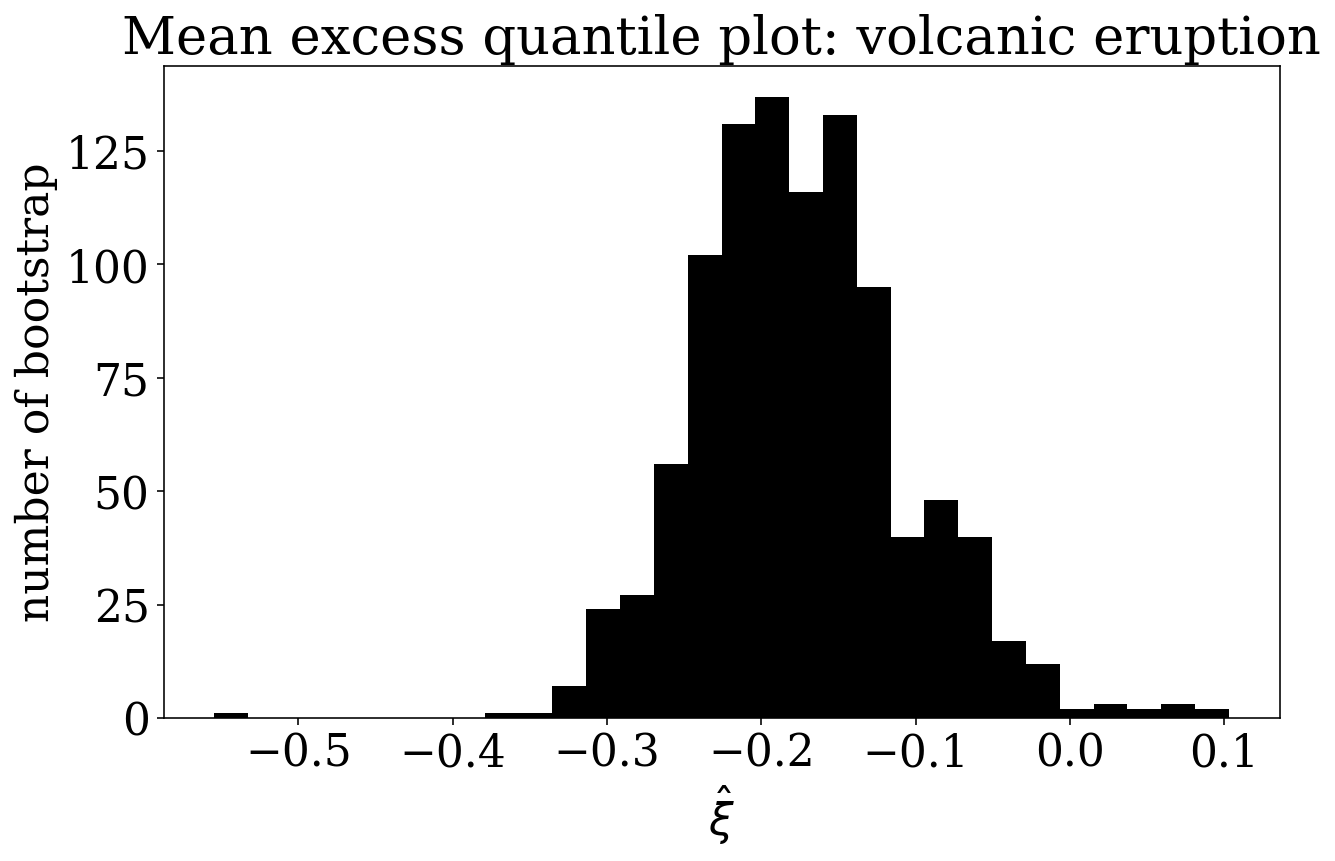

In [ ]:
X = X[1:idx,:]
y = log_mean_excess[1:idx]
m = len(y)

b = 1000
xi_boots = np.zeros(b)

for i in range(b):
    sample_int = np.random.randint(m, size=m)
    max_index = np.max(sample_int)
    reg = LinearRegression(fit_intercept = False).fit(X[sample_int,:]-X[max_index,:],y[sample_int]-y[max_index])
    xi_boots[i] = reg.coef_[0]

plt.hist(xi_boots,bins = 30,color = 'black')
plt.title('Mean excess quantile plot: volcanic eruption')
plt.xlabel('$\hat{\u03BE}$')
plt.ylabel('number of bootstrap')

# Plot 5: Fitted return levels vs empirical return levels, including confidence intervals

In [ ]:
## calculate empirical return period
empirical_VEI = np.unique(np.sort(volcano_data['M']))
empirical_return_period = np.zeros(len(empirical_VEI))
for i, vei in enumerate(empirical_VEI):
    empirical_return_period[i] = (2000-1750)/np.sum(volcano_data['M']>=vei)

In [ ]:
from scipy.stats import genpareto
def return_period_function(return_level_x, u, xi, mu, sigma, data, time_interval = 250):
    ## 1−𝐺𝑃𝐷(𝑦),y = x - u
    one_minus_GPD_y = 1-genpareto.cdf(return_level_x-u,xi,mu,sigma)

    ## Pu = 𝑃(𝑋>𝑢)
    Pu = np.sum(data>=u)/time_interval

    ## P(X>x)
    exceedance_prob = one_minus_GPD_y*Pu

    ## T = 1/P(X>x)
    return_period_T = 1/exceedance_prob

    return return_level_x, return_period_T

In [ ]:
u = threshold
bootstrap_predictions = np.zeros((3,len(np.arange(u,20,0.01))))
xi_pred = [np.quantile(xi_boots,0.9),np.quantile(xi_boots,0.5),np.quantile(xi_boots,0.1)]
i = 0
for xi_estimate in xi_pred:
    xi, mu, sigma = genpareto.fit(volcano_data['M'][volcano_data['M']>=u]-u, 
                                  fc = xi_estimate,floc = 0)
    return_level_x, bootstrap_predictions[i,:] = return_period_function(np.arange(u,20,0.01), u, xi, mu, sigma, volcano_data['M'], time_interval = 250)
    i = i + 1
maximum_magnitude = [np.round(np.arange(u,20,0.01)[np.where(bootstrap_predictions[i,:]==np.inf)[0][0]],2) for i in range(3)]

Text(0.5, 1.0, 'Empirical return level plot')

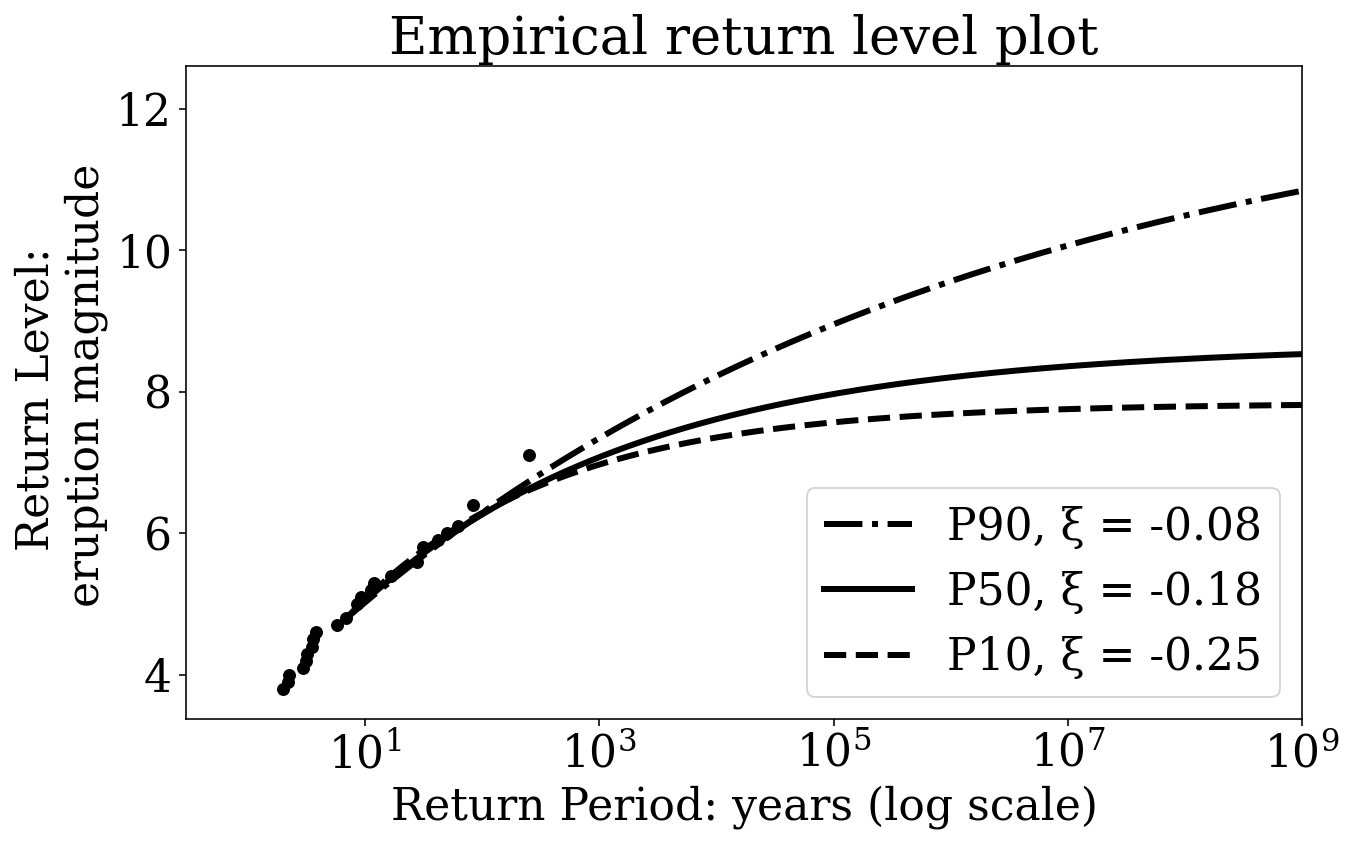

In [ ]:
plt.scatter(empirical_return_period,empirical_VEI,s = 30, color = 'black')
plt.plot(bootstrap_predictions[0,:],return_level_x,linewidth = 3, linestyle = '-.',color = 'black',label = 'P90, \u03BE = '+str(np.round(xi_pred[0],2)))
plt.plot(bootstrap_predictions[1,:],return_level_x,linewidth = 3, linestyle = '-',color = 'black',label = 'P50, \u03BE = '+str(np.round(xi_pred[1],2)))
plt.plot(bootstrap_predictions[2,:],return_level_x,linewidth = 3, linestyle = '--',color = 'black',label = 'P10, \u03BE = '+str(np.round(xi_pred[2],2)))
plt.legend(loc = 'lower right')
plt.xscale('log',basex = 10)
plt.xlim(xmax = 1e9)
plt.xlabel('Return Period: years (log scale)')
plt.ylabel('Return Level: \n eruption magnitude')
plt.title('Empirical return level plot')

Text(0.5, 1.0, 'Empirical return level plot')

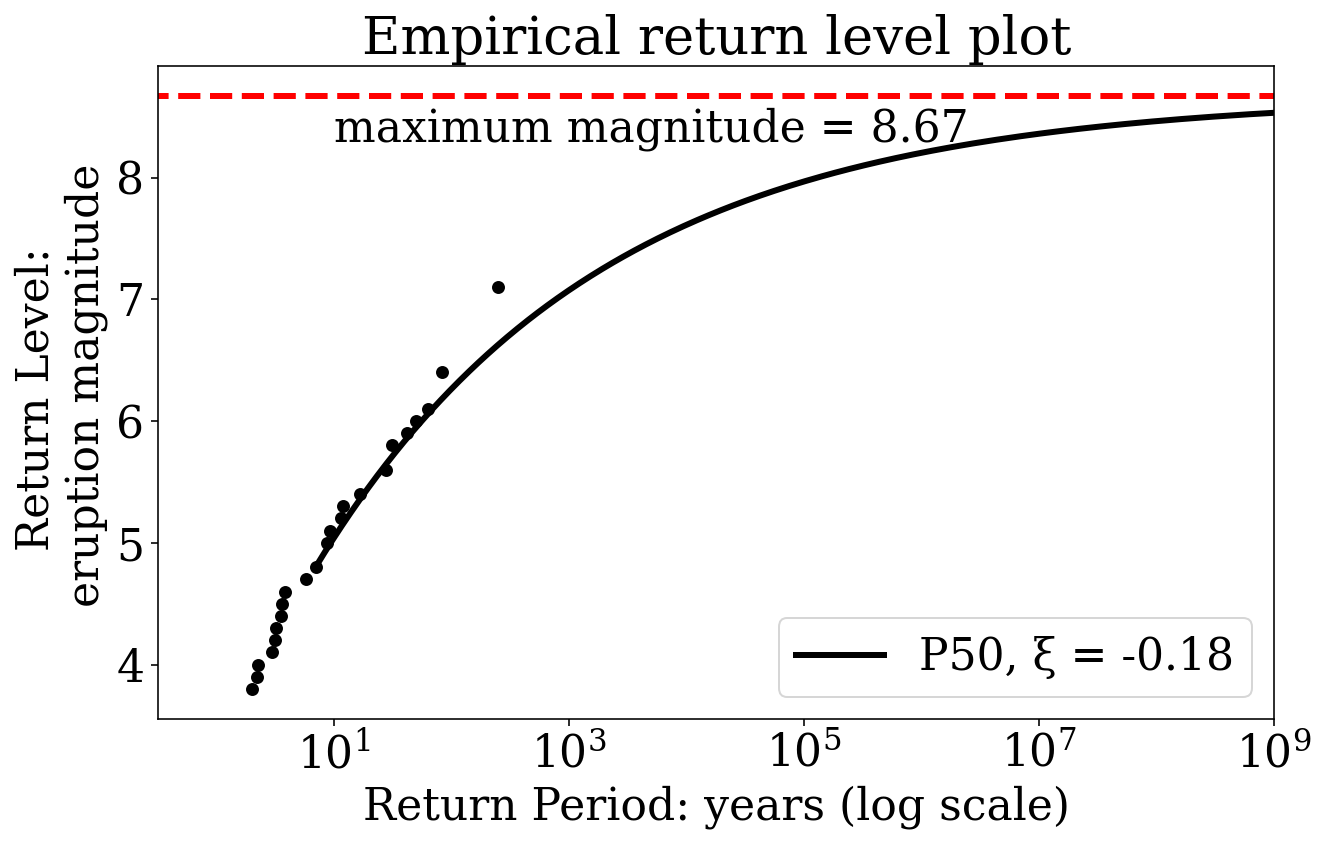

In [ ]:
plt.scatter(empirical_return_period,empirical_VEI,s = 30, color = 'black')

plt.plot(bootstrap_predictions[1,:],return_level_x,linewidth = 3, linestyle = '-',color = 'black',label = 'P50, \u03BE = '+str(np.round(xi_pred[1],2)))
plt.hlines(y = maximum_magnitude[1],xmin = 0,xmax = 1e9,linewidth = 3, linestyle = '--',color = 'red')
plt.text(10,8.3, 'maximum magnitude = '+str(maximum_magnitude[1]))
plt.legend(loc = 'lower right')
plt.xscale('log',basex = 10)
plt.xlim(xmax = 1e9)
plt.xlabel('Return Period: years (log scale)')
plt.ylabel('Return Level: \n eruption magnitude')
plt.title('Empirical return level plot')

the return level of 2000 years and the return period of VEI = 8.


Text(0.5, 1.0, 'Empirical return level plot')

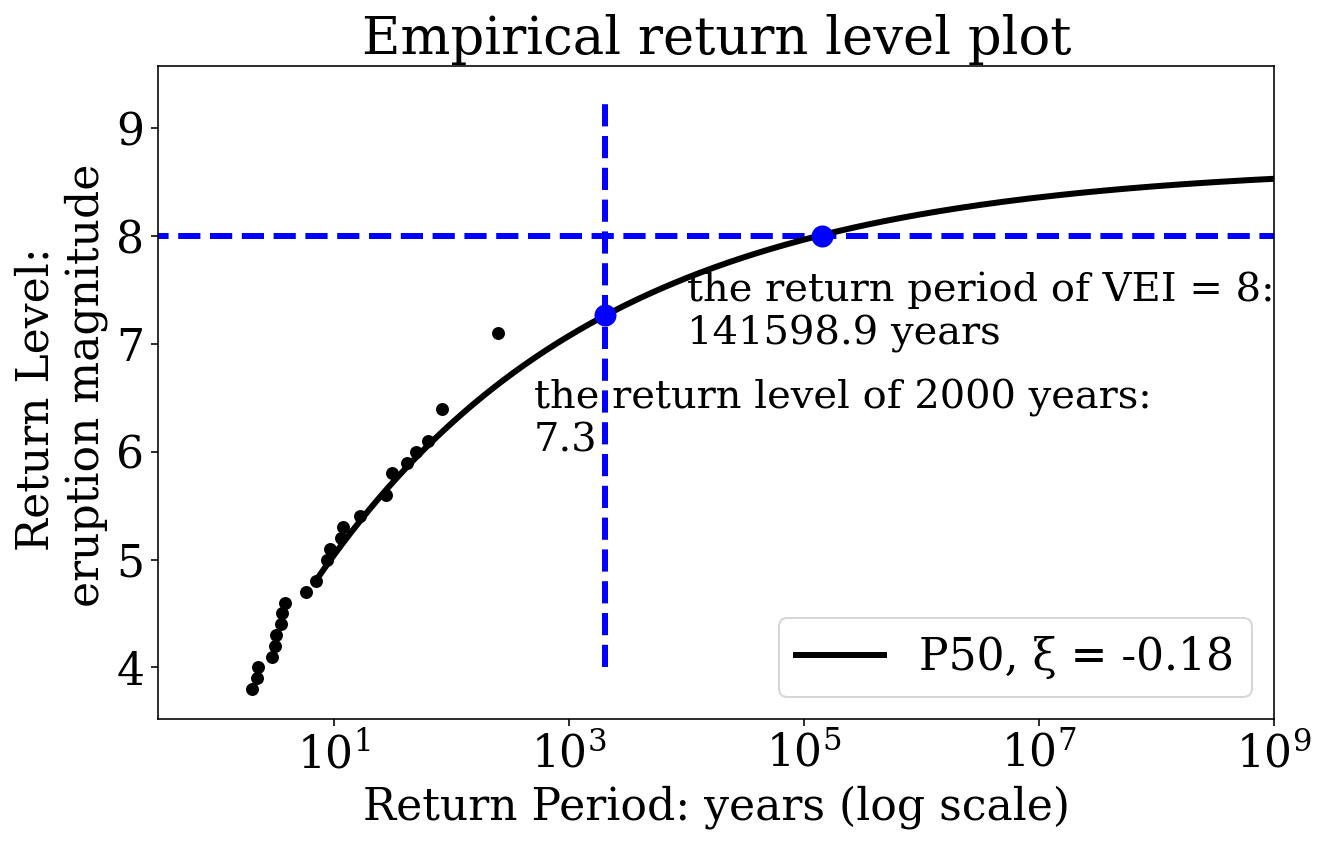

In [ ]:
plt.scatter(empirical_return_period,empirical_VEI,s = 30, color = 'black')
plt.plot(bootstrap_predictions[1,:],return_level_x,linewidth = 3, linestyle = '-',color = 'black',label = 'P50, \u03BE = '+str(np.round(xi_pred[1],2)))
plt.hlines(y = 8,xmin = 0,xmax = 1e9,linewidth = 3, linestyle = '--',color = 'blue')
plt.vlines(x = 2e3,ymin = 4,ymax = 9.3,linewidth = 3, linestyle = '--',color = 'blue')
return_period_VEI_8 = bootstrap_predictions[1,:][np.where(return_level_x>=8)[0][0]]
plt.scatter(return_period_VEI_8,8,zorder = 100,s = 100,color = 'blue')
return_level_2000_year = np.arange(u,20,0.01)[bootstrap_predictions[1,:]>=2000][0]
plt.scatter(2000,return_level_2000_year,zorder = 100,s = 100,color = 'blue')
plt.text(1e4, 7, 'the return period of VEI = 8: \n'+str(np.round(return_period_VEI_8,1))+' years',fontsize = 20)
plt.text(5e2, 6, 'the return level of 2000 years: \n'+str(np.round(return_level_2000_year,1)),fontsize = 20)

plt.legend(loc = 'lower right')
plt.xscale('log',basex = 10)
plt.xlim(xmax = 1e9)
plt.xlabel('Return Period: years (log scale)')
plt.ylabel('Return Level: \n eruption magnitude')
plt.title('Empirical return level plot')